In [1]:
import os
os.chdir("/home/yasser/classes/DL26/final_Project")


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.utils.data_fetcher import create_loaders
from src.utils.SRESNET import SRResNet
from src.utils.helper_functions import train_sr, val_sr, plot_sr_progress
import os
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

device : cuda


In [3]:
model = SRResNet().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4
)


In [4]:
from PIL import Image
import torchvision.transforms as T

hr_path="./data/preprocessed/test/HR/austin1_r07_c09.png"
lr_path="./data/preprocessed/test/LR/austin1_r07_c09.png"

lr_img = Image.open(lr_path).convert("RGB")
hr_img = Image.open(hr_path).convert("RGB")


In [5]:
assert hr_img.size[0] == lr_img.size[0] * 4
assert hr_img.size[1] == lr_img.size[1] * 4


In [6]:
to_tensor = T.ToTensor()

lr = to_tensor(lr_img).unsqueeze(0).to(device)  # [1,3,h,w]
hr = to_tensor(hr_img).unsqueeze(0).to(device)  # [1,3,H,W]


In [7]:
sr = model(lr)
print(sr.shape, hr.shape)


torch.Size([1, 3, 192, 192]) torch.Size([1, 3, 192, 192])


In [8]:
from torch.amp import autocast, GradScaler

model.train()
scaler = GradScaler()

num_iters = 10000  # iterations, NOT epochs

for i in range(num_iters):
    optimizer.zero_grad()

    with autocast(device_type="cuda"):
        sr = model(lr)       # SRResNet upsamples internally
        loss = criterion(sr, hr)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    if i % 100 == 0:
        psnr = 10 * torch.log10(1.0 / loss).item()
        print(f"Iter {i:04d} | Loss: {loss.item():.6f} | PSNR: {psnr:.2f} dB")


Iter 0000 | Loss: 0.354178 | PSNR: 4.51 dB
Iter 0100 | Loss: 0.046342 | PSNR: 13.34 dB
Iter 0200 | Loss: 0.034764 | PSNR: 14.59 dB
Iter 0300 | Loss: 0.026390 | PSNR: 15.79 dB
Iter 0400 | Loss: 0.020049 | PSNR: 16.98 dB
Iter 0500 | Loss: 0.016491 | PSNR: 17.83 dB
Iter 0600 | Loss: 0.013989 | PSNR: 18.54 dB
Iter 0700 | Loss: 0.011928 | PSNR: 19.23 dB
Iter 0800 | Loss: 0.010567 | PSNR: 19.76 dB
Iter 0900 | Loss: 0.009371 | PSNR: 20.28 dB
Iter 1000 | Loss: 0.008329 | PSNR: 20.79 dB
Iter 1100 | Loss: 0.007404 | PSNR: 21.31 dB
Iter 1200 | Loss: 0.007014 | PSNR: 21.54 dB
Iter 1300 | Loss: 0.006615 | PSNR: 21.79 dB
Iter 1400 | Loss: 0.005968 | PSNR: 22.24 dB
Iter 1500 | Loss: 0.005560 | PSNR: 22.55 dB
Iter 1600 | Loss: 0.005365 | PSNR: 22.70 dB
Iter 1700 | Loss: 0.004618 | PSNR: 23.36 dB
Iter 1800 | Loss: 0.004970 | PSNR: 23.04 dB
Iter 1900 | Loss: 0.004717 | PSNR: 23.26 dB
Iter 2000 | Loss: 0.004230 | PSNR: 23.74 dB
Iter 2100 | Loss: 0.004006 | PSNR: 23.97 dB
Iter 2200 | Loss: 0.004105 | PSNR

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1213261..1.0092711].


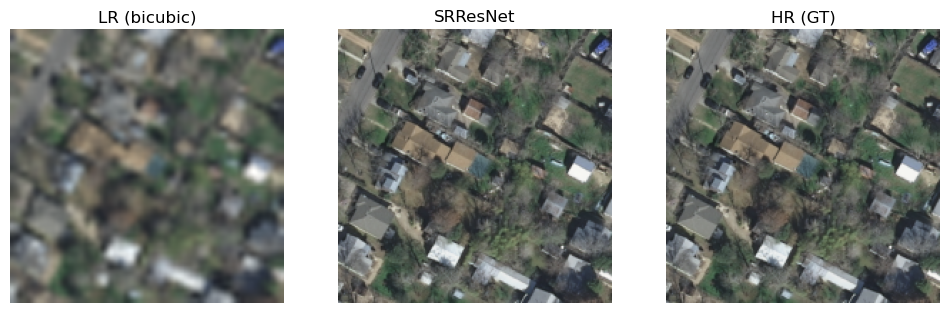

In [9]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sr = model(lr).clamp(0, 1)

sr_img = sr.squeeze(0).permute(1, 2, 0).cpu()
hr_img = hr.squeeze(0).permute(1, 2, 0).cpu()
lr_up = torch.nn.functional.interpolate(
    lr, scale_factor=4, mode="bicubic", align_corners=False
)
lr_up = lr_up.squeeze(0).permute(1, 2, 0).cpu()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("LR (bicubic)"); plt.imshow(lr_up); plt.axis("off")
plt.subplot(1,3,2); plt.title("SRResNet"); plt.imshow(sr_img); plt.axis("off")
plt.subplot(1,3,3); plt.title("HR (GT)"); plt.imshow(hr_img); plt.axis("off")
plt.show()


In [10]:
import torch

def compute_psnr(sr, hr, max_val=1.0):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return 100.0
    psnr = 10 * torch.log10((max_val ** 2) / mse)
    return psnr.item()


In [11]:
with torch.no_grad():
    sr = model(lr).clamp(0, 1)

psnr = compute_psnr(sr, hr)
print(f"PSNR: {psnr:.2f} dB")


PSNR: 52.39 dB
